# Обработка пропусков в данных, кодирование категориальных признаков, масштабирование данных.

Мы научимся обрабатывать пропуски в данных для количественных (числовых) и категориальных признаков и масштабировать данные. Также мы научимся преобразовывать категориальные признаки в числовые.

### В чем состоит проблема?

- Если в данных есть пропуски, то большинство алгоритмов машинного обучения не будут с ними работать. Даже корреляционная матрица не будет строиться корректно.
- Большинство алгоритмов машинного обучения требуют явного перекодирования категориальных признаков в числовые. Даже если алгоритм не требует этого явно, такое перекодирование возможно стоит попробовать, чтобы повысить качество модели.
- Большинство алгоритмов показывает лучшее качество на масштабированных признаках, в особенности алгоритмы, использующие методы градиентного спуска.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

## Загрузка и первичный анализ данных

Используем данные из(https://www.kaggle.com/datasets/gauravkumar2525/shark-attacks?resource=download)

In [46]:
# Будем использовать только обучающую выборку
data = pd.read_csv('synthetic_dataset.csv', sep=",")

In [47]:
# размер набора данных
data.shape

(4362, 5)

In [48]:
# типы колонок
data.dtypes

Category     object
Price       float64
Rating      float64
Stock        object
Discount    float64
dtype: object

In [49]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Category    2748
Price        174
Rating      2050
Stock       1352
Discount     392
dtype: int64

In [50]:
# Первые 5 строк датасета
data.head()

,Category,Price,Rating,Stock,Discount
0,NaN,5548.0,1.870322,NaN,0.0
1,NaN,3045.0,4.757798,NaN,38.0
2,NaN,4004.0,NaN,In Stock,0.0
3,NaN,4808.0,1.492085,NaN,33.0
4,NaN,1817.0,NaN,Out of Stock,23.0


In [51]:
total_count = data.shape[0]
print('Всего строк: {}'.format(total_count))

Всего строк: 4362


# Обработка пропусков в данных

## Простые стратегии - удаление или заполнение нулями

Удаление колонок, содержащих пустые значения
`res = data.dropna(axis=1, how='any')`

Удаление строк, содержащих пустые значения
`res = data.dropna(axis=0, how='any')`

[Документация](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html)

**Удаление может производиться для группы строк или колонок.**

In [52]:
# Удаление колонок, содержащих пустые значения
data_new_1 = data.dropna(axis=1, how='any')
(data.shape, data_new_1.shape)

((4362, 5), (4362, 0))

In [53]:
# Удаление строк, содержащих пустые значения
data_new_2 = data.dropna(axis=0, how='any')
(data.shape, data_new_2.shape)

((4362, 5), (540, 5))

In [54]:
data.head()

,Category,Price,Rating,Stock,Discount
0,NaN,5548.0,1.870322,NaN,0.0
1,NaN,3045.0,4.757798,NaN,38.0
2,NaN,4004.0,NaN,In Stock,0.0
3,NaN,4808.0,1.492085,NaN,33.0
4,NaN,1817.0,NaN,Out of Stock,23.0


In [55]:
# Заполнение всех пропущенных значений нулями
# В данном случае это некорректно, так как нулями заполняются в том числе категориальные колонки
data_new_3 = data.fillna(0)
data_new_3.head()

,Category,Price,Rating,Stock,Discount
0,0,5548.0,1.870322,0,0.0
1,0,3045.0,4.757798,0,38.0
2,0,4004.0,0.000000,In Stock,0.0
3,0,4808.0,1.492085,0,33.0
4,0,1817.0,0.000000,Out of Stock,23.0


## "Внедрение значений" - импьютация (imputation)

### Обработка пропусков в числовых данных

In [56]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Price. Тип данных float64. Количество пустых значений 174, 3.99%.
Колонка Rating. Тип данных float64. Количество пустых значений 2050, 47.0%.
Колонка Discount. Тип данных float64. Количество пустых значений 392, 8.99%.


In [57]:
# Фильтр по колонкам с пропущенными значениями
data_num = data[num_cols]
data_num

,Price,Rating,Discount
0,5548.0,1.870322,0.0
1,3045.0,4.757798,38.0
2,4004.0,NaN,0.0
3,4808.0,1.492085,33.0
4,1817.0,NaN,23.0
...,...,...,...
4357,4436.0,4.728335,49.0
4358,6236.0,NaN,4.0
4359,3283.0,NaN,9.0
4360,2999.0,4.425995,40.0


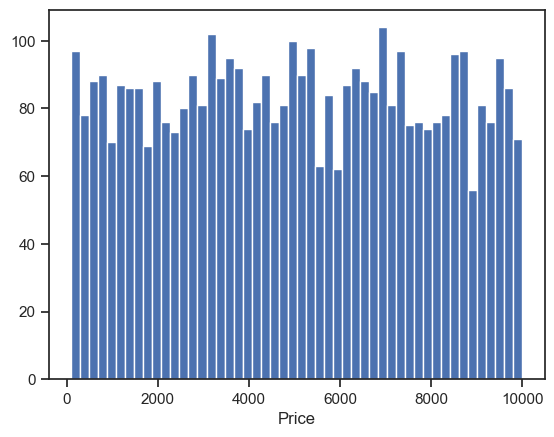

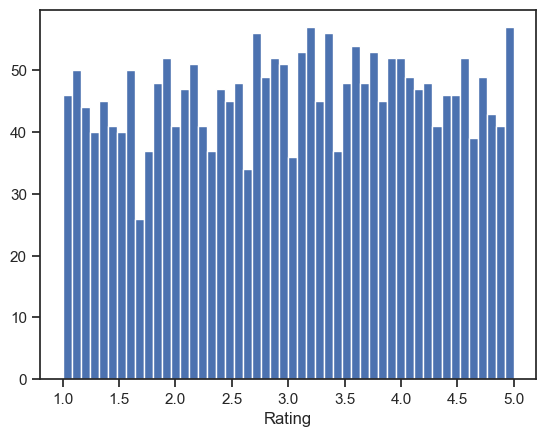

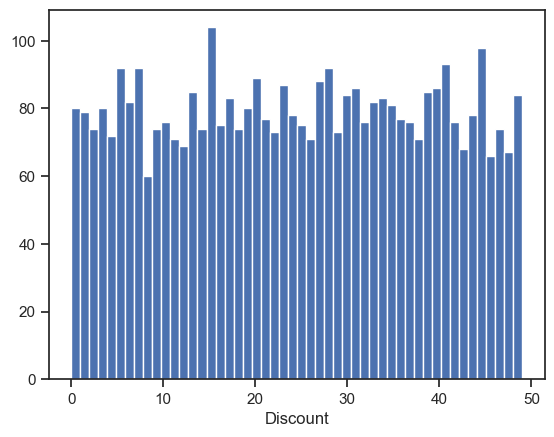

In [58]:
# Гистограмма по признакам
for col in data_num:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Будем использовать встроенные средства импьютации библиотеки scikit-learn - https://scikit-learn.org/stable/modules/impute.html

In [59]:
data_num_rating = data_num[['Rating']]
data_num_rating.head()

,Rating
0,1.870322
1,4.757798
2,NaN
3,1.492085
4,NaN


In [32]:
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator

In [60]:
# Фильтр для проверки заполнения пустых значений
indicator = MissingIndicator()
mask_missing_values_only = indicator.fit_transform(data_num_rating)
mask_missing_values_only

array([[False],
       [False],
       [ True],
       ...,
       [ True],
       [False],
       [False]])

С помощью класса [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) можно проводить импьютацию различными [показателями центра распределения](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D0%BA%D0%B0%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D0%B8_%D1%86%D0%B5%D0%BD%D1%82%D1%80%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)

In [61]:
strategies=['mean', 'median', 'most_frequent']

In [62]:
def test_num_impute(strategy_param):
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(data_num_rating)
    return data_num_imp[mask_missing_values_only]

In [63]:
strategies[0], test_num_impute(strategies[0])

('mean',
 array([3.03829252, 3.03829252, 3.03829252, ..., 3.03829252, 3.03829252,
        3.03829252]))

In [64]:
strategies[1], test_num_impute(strategies[1])

('median',
 array([3.08206005, 3.08206005, 3.08206005, ..., 3.08206005, 3.08206005,
        3.08206005]))

In [65]:
strategies[2], test_num_impute(strategies[2])

('most_frequent',
 array([1.0003662, 1.0003662, 1.0003662, ..., 1.0003662, 1.0003662,
        1.0003662]))

In [66]:
# Более сложная функция, которая позволяет задавать колонку и вид импьютации
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    return column, strategy_param, filled_data.size, filled_data[0], filled_data[filled_data.size-1]

In [68]:
data[['Rating']].describe()

,Rating
count,2312.000000
mean,3.038293
std,1.143074
min,1.000366
25%,2.069490
50%,3.082060
75%,4.008620
max,4.997818


In [70]:
test_num_impute_col(data, 'Rating', strategies[0])

('Rating', 'mean', 2050, 3.0382925191086185, 3.0382925191086185)

In [69]:
test_num_impute_col(data, 'Rating', strategies[1])

('Rating', 'median', 2050, 3.0820600518841306, 3.0820600518841306)

In [71]:
test_num_impute_col(data, 'Rating', strategies[2])

('Rating', 'most_frequent', 2050, 1.0003662024741131, 1.0003662024741131)

### Обработка пропусков в категориальных данных

In [72]:
# Выберем категориальные колонки с пропущенными значениями
# Цикл по колонкам датасета
cat_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='object'):
        cat_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))

Колонка Category. Тип данных object. Количество пустых значений 2748, 63.0%.
Колонка Stock. Тип данных object. Количество пустых значений 1352, 30.99%.


**Какие из этих колонок Вы бы выбрали или не выбрали для построения модели?**

Класс SimpleImputer можно использовать для категориальных признаков со стратегиями "most_frequent" или "constant".

In [73]:
cat_temp_data = data[['Category']]
cat_temp_data.head()

,Category
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [74]:
cat_temp_data['Category'].unique()

array([nan, 'C', 'A', 'B', 'D'], dtype=object)

In [75]:
cat_temp_data[cat_temp_data['Category'].isnull()].shape

(2748, 1)

In [76]:
# Импьютация наиболее частыми значениями
imp2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data_imp2 = imp2.fit_transform(cat_temp_data)
data_imp2

array([['C'],
       ['C'],
       ['C'],
       ...,
       ['C'],
       ['D'],
       ['C']], dtype=object)

In [77]:
# Пустые значения отсутствуют
np.unique(data_imp2)

array(['A', 'B', 'C', 'D'], dtype=object)

In [78]:
# Импьютация константой
imp3 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_imp3 = imp3.fit_transform(cat_temp_data)
data_imp3

array([['NA'],
       ['NA'],
       ['NA'],
       ...,
       ['NA'],
       ['D'],
       ['NA']], dtype=object)

In [79]:
np.unique(data_imp3)

array(['A', 'B', 'C', 'D', 'NA'], dtype=object)

In [80]:
data_imp3[data_imp3=='NA'].size

2748

# Преобразование категориальных признаков в числовые

In [81]:
cat_enc = pd.DataFrame({'c1':data_imp2.T[0]})
cat_enc

,c1
0,C
1,C
2,C
3,C
4,C
...,...
4357,C
4358,B
4359,C
4360,D


## Кодирование категорий целочисленными значениями (label encoding)

В этом случае уникальные значения категориального признака кодируются целыми числами.

В scikit-learn для такого кодирования используется два класса :

- [LabelEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) - который ориентирован на применение к одному признаку. Этот класс прежде всего предназначен для кодирования целевого признака, но может быть также использован для последовательного кодирования отдельных нецелевых признаков.
- [OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html) - который ориентирован на применение к матрице объект-признак, то есть для кодирования матрицы нецелевых признаков.

### Использование LabelEncoder

In [82]:
from sklearn.preprocessing import LabelEncoder

In [83]:
cat_enc['c1'].unique()

array(['C', 'A', 'B', 'D'], dtype=object)

In [84]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(cat_enc['c1'])

In [85]:
# Наименования категорий в соответствии с порядковыми номерами

# Свойство называется classes, потому что предполагается что мы решаем 
# задачу классификации и каждое значение категории соответствует 
# какому-либо классу целевого признака

le.classes_

array(['A', 'B', 'C', 'D'], dtype=object)

In [86]:
cat_enc_le

array([2, 2, 2, ..., 2, 3, 2])

In [87]:
np.unique(cat_enc_le)

array([0, 1, 2, 3])

In [88]:
# В этом примере видно, что перед кодированием 
# уникальные значения признака сортируются в лексикографиеском порядке
le.inverse_transform([0, 1, 2, 3])

array(['A', 'B', 'C', 'D'], dtype=object)

### Использование OrdinalEncoder

In [89]:
from sklearn.preprocessing import OrdinalEncoder

In [90]:
data_oe = data[['Category', 'Stock']]
data_oe.head()

,Category,Stock
0,NaN,NaN
1,NaN,NaN
2,NaN,In Stock
3,NaN,NaN
4,NaN,Out of Stock


In [91]:
imp4 = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='NA')
data_oe_filled = imp4.fit_transform(data_oe)
data_oe_filled

array([['NA', 'NA'],
       ['NA', 'NA'],
       ['NA', 'In Stock'],
       ...,
       ['NA', 'Out of Stock'],
       ['D', 'NA'],
       ['NA', 'NA']], dtype=object)

In [92]:
oe = OrdinalEncoder()
cat_enc_oe = oe.fit_transform(data_oe_filled)
cat_enc_oe

array([[4., 1.],
       [4., 1.],
       [4., 0.],
       ...,
       [4., 2.],
       [3., 1.],
       [4., 1.]])

In [93]:
# Уникальные значения 1 признака
np.unique(cat_enc_oe[:, 0])

array([0., 1., 2., 3., 4.])

In [94]:
# Уникальные значения 2 признака
np.unique(cat_enc_oe[:, 1])

array([0., 1., 2.])

In [95]:
# Наименования категорий в соответствии с порядковыми номерами
oe.categories_

[array(['A', 'B', 'C', 'D', 'NA'], dtype=object),
 array(['In Stock', 'NA', 'Out of Stock'], dtype=object)]

In [96]:
# Обратное преобразование
oe.inverse_transform(cat_enc_oe)

array([['NA', 'NA'],
       ['NA', 'NA'],
       ['NA', 'In Stock'],
       ...,
       ['NA', 'Out of Stock'],
       ['D', 'NA'],
       ['NA', 'NA']], dtype=object)

### Проблемы использования LabelEncoder и OrdinalEncoder

Необходимо отметить, что LabelEncoder и OrdinalEncoder могут использоваться только для категориальных признаков в номинальных шкалах (для которых отсутствует порядок), например города, страны, названия рек и т.д. 

Это связано с тем, что задать какой-либо порядок при кодировании с помощью LabelEncoder и OrdinalEncoder невозможно, они сортируют категории в лексикографическом порядке.

При этом кодирование целыми числами создает фиктивное отношение порядка (1 < 2 < 3 < ...) которого не было в исходных номинальных шкалах. Данное отношение порядка может негативно повлиять на построение модели машинного обучения.

## Кодирование категорий наборами бинарных значений - [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

В этом случае каждое уникальное значение признака становится новым отдельным признаком.

In [97]:
from sklearn.preprocessing import OneHotEncoder

In [98]:
ohe = OneHotEncoder()
cat_enc_ohe = ohe.fit_transform(cat_enc[['c1']])

In [99]:
cat_enc.shape

(4362, 1)

In [100]:
cat_enc_ohe.shape

(4362, 4)

In [101]:
cat_enc_ohe

<4362x4 sparse matrix of type '<class 'numpy.float64'>'
	with 4362 stored elements in Compressed Sparse Row format>

In [102]:
cat_enc_ohe.todense()[0:10]

matrix([[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]])

In [103]:
cat_enc.head(10)

,c1
0,C
1,C
2,C
3,C
4,C
5,C
6,C
7,A
8,A
9,C


## [Pandas get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html) - быстрый вариант one-hot кодирования

In [104]:
pd.get_dummies(cat_enc).head()

,c1_A,c1_B,c1_C,c1_D
0,False,False,True,False
1,False,False,True,False
2,False,False,True,False
3,False,False,True,False
4,False,False,True,False


In [105]:
pd.get_dummies(cat_temp_data, dummy_na=True).head()

,Category_A,Category_B,Category_C,Category_D,Category_nan
0,False,False,False,False,True
1,False,False,False,False,True
2,False,False,False,False,True
3,False,False,False,False,True
4,False,False,False,False,True


# Масштабирование данных

Термины "масштабирование" и "нормализация" часто используются как синонимы, но это неверно. Масштабирование предполагает изменение диапазона измерения величины, а нормализация - изменение распределения этой величины. В этом разделе рассматривается только масштабирование.

Если признаки лежат в различных диапазонах, то необходимо их нормализовать. Как правило, применяют два подхода:
- MinMax масштабирование:
$$ x_{новый} = \frac{x_{старый} - min(X)}{max(X)-min(X)} $$

В этом случае значения лежат в диапазоне от 0 до 1.
- Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0):
$$ x_{новый} = \frac{x_{старый} - AVG(X) }{\sigma(X)} $$

В этом случае большинство значений попадает в диапазон от -3 до 3.

где $X$ - матрица объект-признак, $AVG(X)$ - среднее значение, $\sigma$ - среднеквадратичное отклонение.

In [106]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer

## [MinMax масштабирование](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [107]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[['Rating']])

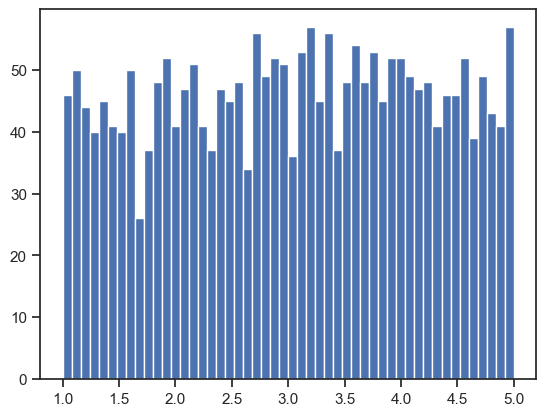

In [108]:
plt.hist(data['Rating'], 50)
plt.show()

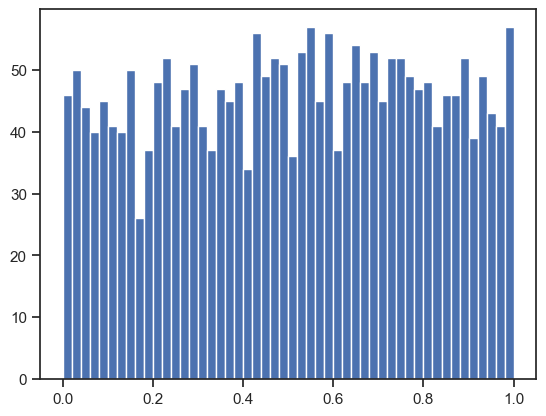

In [109]:
plt.hist(sc1_data, 50)
plt.show()

## Масштабирование данных на основе [Z-оценки](https://ru.wikipedia.org/wiki/Z-%D0%BE%D1%86%D0%B5%D0%BD%D0%BA%D0%B0) - [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler)

In [110]:
sc2 = StandardScaler()
sc2_data = sc2.fit_transform(data[['Rating']])

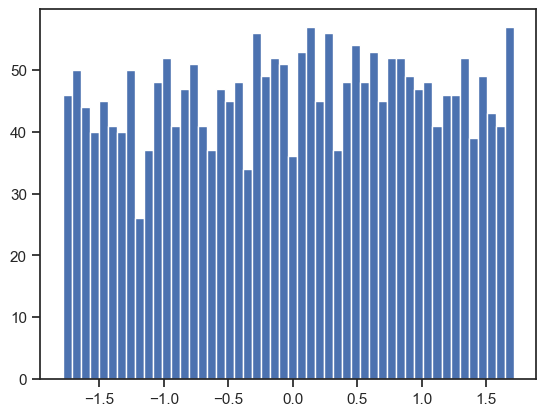

In [111]:
plt.hist(sc2_data, 50)
plt.show()

# Дополнительные источники
- [Руководство scikit-learn по предобработке данных](https://scikit-learn.org/stable/modules/preprocessing.html)
- [Kaggle Data Cleaning Challenge: Handling missing values (упражнения с пояснениями по обработке пропущенных значений и масштабированию признаков)](https://www.kaggle.com/rtatman/data-cleaning-challenge-handling-missing-values)
- [Краткое руководство по категориальным признакам](https://towardsdatascience.com/encoding-categorical-features-21a2651a065c)